In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%pip install accelerate peft bitsandbytes
%pip install langchain langchain-community sentence-transformers langchain-huggingface faiss-cpu transformers



os.environ["hf_token"] = ""
from huggingface_hub import login
login(os.environ["hf_token"] )

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain_huggingface import HuggingFacePipeline

# Use Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

In [ ]:

model_id="rakibulnahin/travel-chat-llama2-7b-lora-4bit-finetuned"
peft_config = PeftConfig.from_pretrained(model_id)

# Load the base model in 4-bit
base_model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    load_in_4bit=True,
    device_map="auto"
)

# Load LoRA adapter weights
model = PeftModel.from_pretrained(base_model, model_id)

## Running Model

In [ ]:
model.eval()
prompt = "Make a travel plan for a exciting experience in Vietnam with friends including various activites and relaxing experience"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=1024,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.1
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

In [6]:
# from sentence_transformers import SentenceTransformer
# embedder = HuggingFaceEmbeddings(model_name="thuan9889/llama_embedding_model_v1", model_kwargs={"device": "cpu"})
embedder = HuggingFaceEmbeddings(model_name="thuan9889/llama_embedding_model_v1")


/tmp/ipykernel_38/2154015721.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="thuan9889/llama_embedding_model_v1")
2026-01-11 18:36:16.151781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768156576.353683      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768156576.412959      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to registe

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

# Simple Vector RAG

In [7]:
raw_docs = [
    "Sydney has nice warm weather with beautiful beaches and culture",
    "Adelaide is mostly cold but has very nice sceneries however its feels lonely"
]

splitter = RecursiveCharacterTextSplitter(
    chunk_size=30,
    chunk_overlap=5
)
chunks = splitter.create_documents(raw_docs)

print(chunks)



[Document(metadata={}, page_content='Sydney has nice warm weather'), Document(metadata={}, page_content='with beautiful beaches and'), Document(metadata={}, page_content='and culture'), Document(metadata={}, page_content='Adelaide is mostly cold but'), Document(metadata={}, page_content='but has very nice sceneries'), Document(metadata={}, page_content='however its feels lonely')]


In [8]:
vectorstore = FAISS.from_documents(chunks, embedder)


In [9]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [11]:
import torch
model_id = "meta-llama/Llama-2-7b-chat-hf"

# 1. Load Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16, # Use float16 to save memory
    device_map="auto"          # Automatically uses GPU if available
)



config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

NameError: name 'pipeline' is not defined

In [13]:
# 2. Create a Transformers Pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    repetition_penalty=1.1
)

# 3. Wrap it in LangChain's HuggingFacePipeline
# This makes it an "instance of Runnable" which LangChain requires
local_llm = HuggingFacePipeline(pipeline=pipe)

# 4. Pass the wrapped model to your chain
qa_chain = RetrievalQA.from_chain_type(
    llm=local_llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

Device set to use cuda:0


In [16]:
query = "Where can I in a lonely beach?"
print(qa_chain.invoke(query)["result"])

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

with beautiful beaches and

however its feels lonely

Sydney has nice warm weather

Adelaide is mostly cold but

Question: Where can I in a lonely beach?
Helpful Answer: Adelaide! It's cold there, so it will match your mood.


# Image segmentation model

In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:03<00:00, 55.8MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [6]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://www.thehotelguru.com/_images/62/e0/62e06d414dc5e7e5cff04d38164306ae/s1166x656.jpg", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [7]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

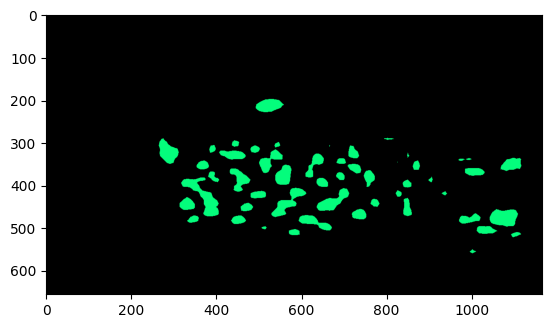

In [8]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

In [10]:
# !pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 86.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 131.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 21.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 22.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Mask RCNN

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 69.0MB/s] 


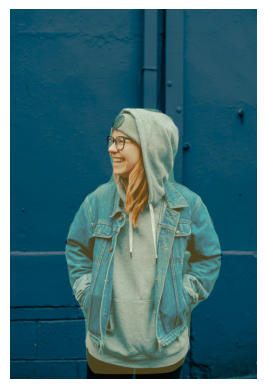

In [1]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from PIL import Image
import requests
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Load Pre-trained Model
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights).eval()
preprocess = weights.transforms()

# 2. Get Image from Web


[42  1  1 42 42 42 42  1  1 28 38  1 42]


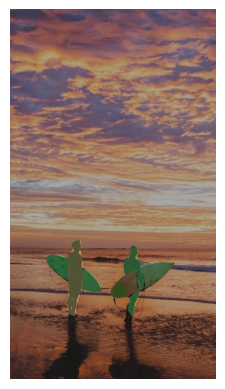

In [31]:
url = "https://www.visitnsw.com/sites/visitnsw/files/styles/portrait_320x575/public/2021-07/177405_Mobile_Header.jpg?itok=I2WGOkf-" # Dog image
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0)

# 3. Run Inference
with torch.no_grad():
    prediction = model(input_tensor)[0]

# 4. Visualization Helper
def plot_results(image, prediction, threshold=0.7):
    image_np = np.array(image)
    masks = prediction['masks'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Filter by confidence threshold
    keep = scores > threshold
    masks = masks[keep]
    
    # Create an overlay
    combined_mask = np.zeros_like(image_np)
    for i in range(len(masks)):
        mask = masks[i, 0] > 0.5  # Binarize the soft mask
        color = np.random.randint(0, 255, (3,)).tolist()
        combined_mask[mask] = color
        
    print(labels)
    final_img = cv2.addWeighted(image_np, 0.7, combined_mask, 0.3, 0)
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

plot_results(img, prediction)

In [26]:
masks

NameError: name 'masks' is not defined

# SegFromer

In [32]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Load a model trained on ADE20K (contains landscape labels like mountain/sea)
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

2026-01-20 03:46:38.296418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768880798.488029      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768880798.545373      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Labels found in image: ['sky', 'tree', 'person', 'earth', 'mountain', 'sea', 'rock', 'sand', 'animal']


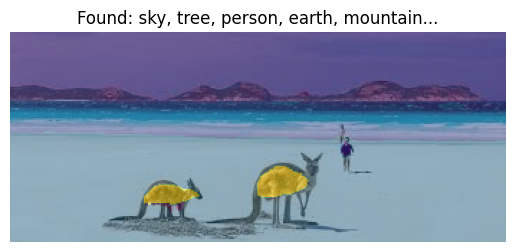

In [35]:


# 2. Get your image
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSSMPwElFny83HOLBOKCWeXevrS_AV7_p_pAg&s" # Beach/Mountain image
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# 3. Process and Predict
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# 4. Resize back to original image size
upsampled_logits = torch.nn.functional.interpolate(
    logits, size=image.size[::-1], mode="bilinear", align_corners=False
)
prediction = upsampled_logits.argmax(1)[0].numpy()

# 5. Get labels found in this specific image
unique_classes = np.unique(prediction)
found_labels = [model.config.id2label[class_id] for class_id in unique_classes]

print(f"Labels found in image: {found_labels}")

# 6. Visualization
plt.imshow(image)
plt.imshow(prediction, alpha=0.5) # Overlay the segments
plt.title(f"Found: {', '.join(found_labels[:5])}...")
plt.axis('off')
plt.show()